# Federated Learning: Train FL Model in Python

In "Create Plan" and "Host Plan" notebooks we've created the
model and the training plan, and hosted both in PyGrid.

Such hosted FL model can be now trained using client libraries, SwiftSyft, KotlinSyft, syft.js.

In this notebook, we'll use FL Client included in the PySyft to do the training.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

import torch as th
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import syft as sy
from syft.federated.fl_client import FLClient
from syft.federated.fl_job import FLJob
from syft.grid.grid_client import GridClient

sy.make_hook(globals())

W0527 14:50:06.697650 21000 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'D:\Anaconda3\envs\syft\lib\site-packages\tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0527 14:50:06.723611 21000 deprecation_wrapper.py:119] From D:\Anaconda3\envs\syft\lib\site-packages\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



Setting up Sandbox...
Done!


Define `on_accepted`, `on_rejected`, `on_error` handlers.

The main training loop is located inside `on_accepted` routine.

In [2]:
cycles_log = []
status = {
    "ended": False
}

# Called when client is accepted into FL cycle
def on_accepted(job: FLJob):
    print(f"Accepted into cycle {len(cycles_log) + 1}!")

    cycle_params = job.client_config
    batch_size = cycle_params["batch_size"]
    lr = cycle_params["lr"]
    max_updates = cycle_params["max_updates"]

    mnist_dataset = th.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size,
        drop_last=True,
        shuffle=True,
    )

    training_plan = job.plans["training_plan"]
    model_params = job.model.tensors()
    losses = []
    accuracies = []

    for batch_idx, (X, y) in enumerate(mnist_dataset):
        X = X.view(batch_size, -1)
        y_oh = th.nn.functional.one_hot(y, 10)
        loss, acc, *model_params = training_plan.torchscript(
            X, y_oh, th.tensor(batch_size), th.tensor(lr), model_params
        )
        losses.append(loss.item())
        accuracies.append(acc.item())
        if batch_idx % 50 == 0:
            print("Batch %d, loss: %f, accuracy: %f" % (batch_idx, loss, acc))
        if batch_idx >= max_updates:
            break

    job.report(model_params)
    # Save losses/accuracies from cycle
    cycles_log.append((losses, accuracies))

# Called when the client is rejected from cycle
def on_rejected(job: FLJob, timeout):
    if timeout is None:
        print(f"Rejected from cycle without timeout (this means FL training is done)")
    else:
        print(f"Rejected from cycle with timeout: {timeout}")
    status["ended"] = True

# Called when error occured
def on_error(job: FLJob, error: Exception):
    print(f"Error: {error}")
    status["ended"] = True

Here we have model gateway address, model name/version,
and define routine that creates FL client and starts the FL process.

In [3]:
# Default pygrid gateway address when running locally
gatewayWsUrl = "ws://127.0.0.1:5000"

# Hosted model
model_name = "mnist"
model_version = "1.0.0"

def create_client_and_run_cycle():
    client = FLClient(url=gatewayWsUrl, auth_token="", verbose=True)
    job = client.new_job(model_name, model_version)

    # Set event handlers
    job.add_listener(job.EVENT_ACCEPTED, on_accepted)
    job.add_listener(job.EVENT_REJECTED, on_rejected)
    job.add_listener(job.EVENT_ERROR, on_error)

    # Shoot!
    job.start()


Now we're ready to start FL training.

We're going to run multiple cycles until the FL model is fully done and see the progress.

As we create & authenticate new client each time,
this emulates multiple different workers requesting a cycle and working on it.

Total number of cycles is going to be `max_workers` times `num_cycles` as set in the server config in "Host Plan" notebook. 

In [4]:
while not status["ended"]:
    create_client_and_run_cycle()

Accepted into cycle 1!
Batch 0, loss: 2.289286, accuracy: 0.156250
Batch 50, loss: 2.230366, accuracy: 0.375000
Batch 100, loss: 2.181740, accuracy: 0.562500
Accepted into cycle 2!
Batch 0, loss: 2.288451, accuracy: 0.125000
Batch 50, loss: 2.230906, accuracy: 0.375000
Batch 100, loss: 2.206937, accuracy: 0.500000
Accepted into cycle 3!
Batch 0, loss: 2.296572, accuracy: 0.078125
Batch 50, loss: 2.239770, accuracy: 0.328125
Batch 100, loss: 2.182474, accuracy: 0.468750
Accepted into cycle 4!
Batch 0, loss: 2.196990, accuracy: 0.421875
Batch 50, loss: 2.134571, accuracy: 0.656250
Batch 100, loss: 2.069101, accuracy: 0.718750
Accepted into cycle 5!
Batch 0, loss: 2.172067, accuracy: 0.578125
Batch 50, loss: 2.106244, accuracy: 0.656250
Batch 100, loss: 2.095053, accuracy: 0.546875
Accepted into cycle 6!
Batch 0, loss: 2.196889, accuracy: 0.406250
Batch 50, loss: 2.130963, accuracy: 0.546875
Batch 100, loss: 2.079938, accuracy: 0.609375
Accepted into cycle 7!
Batch 0, loss: 2.052054, accu

Let's plot loss and accuracy statistics recorded from each client/cycle.
Each such cycle is drawn with different color.

It's visible that loss/accuracy improvement occurs after each 3 cycles,
because pygrid updates the model and creates new checkpoint after
receiving 3 updates from FL clients (this is controlled by `max_workers` parameter).

Cycle 1:	Loss: 2.2441278070506483	Acc: 0.31017945544554454
Cycle 2:	Loss: 2.2435511574886813	Acc: 0.3094059405940594
Cycle 3:	Loss: 2.243639407771649	Acc: 0.28620049504950495
Cycle 4:	Loss: 2.1300594428978346	Acc: 0.5821472772277227
Cycle 5:	Loss: 2.1276729531807477	Acc: 0.572555693069307
Cycle 6:	Loss: 2.1281341845446295	Acc: 0.5742574257425742
Cycle 7:	Loss: 1.9994836538144858	Acc: 0.6602722772277227
Cycle 8:	Loss: 2.000988726568694	Acc: 0.6610457920792079
Cycle 9:	Loss: 2.000479741851882	Acc: 0.6543935643564357
Cycle 10:	Loss: 1.8418968656275532	Acc: 0.6958539603960396
Cycle 11:	Loss: 1.8471758873155801	Acc: 0.6974009900990099
Cycle 12:	Loss: 1.847943136007479	Acc: 0.7145730198019802
Cycle 13:	Loss: 1.6672739215416483	Acc: 0.7264851485148515
Cycle 14:	Loss: 1.6775488109871892	Acc: 0.7336014851485149
Cycle 15:	Loss: 1.6793241618883492	Acc: 0.7255569306930693


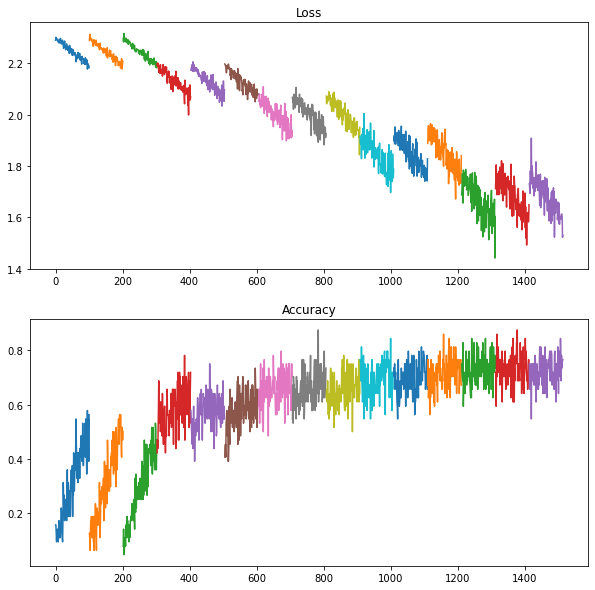

In [5]:
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
offset = 0
for i, cycle_log in enumerate(cycles_log):
    losses, accuracies = cycle_log
    x = range(offset, offset + len(losses))
    axs[0].plot(x, losses)
    axs[1].plot(x, accuracies)
    offset += len(losses)
    print(f"Cycle {i + 1}:\tLoss: {np.mean(losses)}\tAcc: {np.mean(accuracies)}")

### TODO

Bonus track: download resulting model checkpoint and test accuracy on it.

We don't have a way to download model w/o active cycle!

In [6]:
grid = GridClient(id="", address=gatewayWsUrl, secure=False)
#grid.get_model(...)